In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tsfel
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from src.preprocessing.preprocessing  import llenar_val_vacios_str,llenar_val_vacios_ciclo,TsfelVars, ExtraVars,ToDummy, TeEncoder, CardinalityReducer
from src.modeling.feature_selection import feature_selection_by_constant, feature_selection_by_boruta, feature_selection_by_correlation
from src.modeling.simple_models import ChangeTrendPercentajeIdentifierWide,ConstantConsumptionClassifierWide
from src.modeling.supervided_models import LGBMModel, NNModel, LSTMNNModel
from src.helper.helper_functions import plot_roc

In [6]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True) #evita mostrar notacion cientifica

In [7]:
seed = 2021
np.random.seed(seed)

# Paso 1 - Leer datos
***

Descripción de las columnas:

| Variable  | Descripción | Tipo de dato | Cardinalidad |
| :--- | :--- | :--- | :--- |
| Consumo de energía mensual | Indica el comportamiento de consumo a nivel mensual de los usuarios.  Se consideran los últimos 12 consumos.| Numérica | - |
| Actividad | Indica a qué actividad económica se dedica el usuario| Categoría | 284 |
| Tipo de Tarifa | Tarifa que tipo de tarifa se le cobra al usuario| Categoría | 47 |
| Tensión | Tensión instalada al usuario.| Categoría | 18 |
| Material instalacion | Indica tipo de material del medidor instalado| Categoría | 39 |
| Zona | Indica la ubicación geográfica a la que pertenece el usuario | Categoría | 38 |
| Target | Indica si hubo un comportamiento fraudulento o no | Numérica | 0 - 1 |
| Fecha inspección | Indica la fecha en que se inspeccionó al usuario| Fecha | - |

In [8]:
df = pd.read_parquet('../datos/df_anonimizado_02-2023.parquet')

In [9]:
df.head()

,index,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,zona,actividad,tipo_tarifa,nivel_tension,material_instalacion,fecha_inspeccion,target
50345,50345,nan,nan,nan,nan,nan,62.00,58.00,57.00,69.00,95.00,108.00,106.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-05-01,1
191551,191551,92.00,87.00,82.00,74.00,82.00,85.00,86.00,96.00,126.00,104.00,119.00,132.00,zona_647593,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2017-05-01,1
8259,8259,20.00,19.00,27.00,33.00,21.00,21.00,21.00,23.00,18.00,15.00,10.00,14.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_685394,material_instalacion_250300,2016-01-01,1
287671,287671,51.00,70.00,135.00,89.00,112.00,106.00,106.00,52.00,31.00,0.00,0.00,0.00,zona_824219,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2018-01-01,1
306877,306877,0.00,27.00,46.00,43.00,39.00,40.00,37.00,39.00,36.00,34.00,35.00,32.00,None,None,None,None,material_instalacion_143521,2018-03-01,1


In [10]:
df.shape

(42500, 20)

In [11]:
df.dtypes

index                            int64
12_anterior                    float64
11_anterior                    float64
10_anterior                    float64
9_anterior                     float64
8_anterior                     float64
7_anterior                     float64
6_anterior                     float64
5_anterior                     float64
4_anterior                     float64
3_anterior                     float64
2_anterior                     float64
1_anterior                     float64
zona                            object
actividad                       object
tipo_tarifa                     object
nivel_tension                   object
material_instalacion            object
fecha_inspeccion        datetime64[ns]
target                           int64
dtype: object

In [12]:
print("Proporcion de clase : ", 100*df.target.mean())

Proporcion de clase :  5.88235294117647


# Paso 2 - Particionar datos
***

In [13]:
#Particionar por fecha
df_train = df[df.fecha_inspeccion<'2017-08-01'].copy()
df_val = df[(df.fecha_inspeccion>='2017-09-01')&(df.fecha_inspeccion<'2018-01-01')].copy()
df_test = df[df.fecha_inspeccion>='2018-01-01'].copy()

In [14]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(26533, 20)
(4323, 20)
(9995, 20)


In [15]:
print("Proporcion de clase train : ", 100*df_train.target.mean())
print("Proporcion de clase validacion : ", 100*df_val.target.mean())
print("Proporcion de clase test : ", 100*df_test.target.mean())

Proporcion de clase train :  6.410884558851242
Proporcion de clase validacion :  5.389775618783252
Proporcion de clase test :  4.872436218109055


# Paso 3 - Procesamiento de datos y construcción de modelos
***

In [16]:
df_train.isnull().sum()

index                      0
12_anterior               33
11_anterior               31
10_anterior               22
9_anterior                20
8_anterior                18
7_anterior                11
6_anterior                22
5_anterior                36
4_anterior                51
3_anterior                62
2_anterior                81
1_anterior                89
zona                    2882
actividad               2882
tipo_tarifa             2882
nivel_tension           2894
material_instalacion       0
fecha_inspeccion           0
target                     0
dtype: int64

**<ins>Observación :</ins>** 

>En el conjunto de datos existen valores faltantes en las variables de consumo que son de tipos numericas y en las variables categóricas como "zona", "actividad", "tipo_tarifa" y "nivel_tension".

El tratamiento de valores faltantes fue abordado de la siguiente forma : 

- <ins>variables de consumo :</ins> se usaron los metodos ffill y bfill para propagar la observación válida hacia adelante o hacia atras.
- <ins>variables categoricas :</ins>  estas se rellenaron con una nueva categoria denominada "sin_dato".



In [17]:
# Relleno de valores faltantes en serie de consumo.
df_train = llenar_val_vacios_ciclo(df_train, 12)

# Relleno de valores faltantes en variables categoricas
cols_fillna_sindatos = ['zona','actividad','tipo_tarifa','nivel_tension']
df_train = llenar_val_vacios_str(df_train,cols_fillna_sindatos,'sin_dato')

In [18]:
df_train.head()

,index,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,zona,actividad,tipo_tarifa,nivel_tension,material_instalacion,fecha_inspeccion,target
50345,50345,62.00,62.00,62.00,62.00,62.00,62.00,58.00,57.00,69.00,95.00,108.00,106.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-05-01,1
191551,191551,92.00,87.00,82.00,74.00,82.00,85.00,86.00,96.00,126.00,104.00,119.00,132.00,zona_647593,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2017-05-01,1
8259,8259,20.00,19.00,27.00,33.00,21.00,21.00,21.00,23.00,18.00,15.00,10.00,14.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_685394,material_instalacion_250300,2016-01-01,1
9332,9332,212.00,205.00,289.00,221.00,193.00,130.00,142.00,139.00,132.00,140.00,142.00,175.00,zona_489241,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-01-01,1
157486,157486,45.00,43.00,46.00,67.00,52.00,48.00,53.00,57.00,57.00,53.00,59.00,57.00,zona_647593,actividad_960696,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_250300,2017-02-01,1


## Modelos Simples

### Regla : Cambio o disminución en el consumo de energía

>La hipotesis detras de esta regla es que si se existen decrementos bruscos de consumos entonces es un posible comportamiento anomalo.

Configuración : 
- last_base_value : indica la cantidad de periodos anteriores para comparar.
- last_eval_value : indica la cantidad de consumos a ser evaluados.
- threshold : indica la proporción de consumo.

In [19]:
variables_consumo = [x for x in df.columns if '_anterior' in x]
last_base_value,last_eval_value,threshold = 3,1,60
trend_perc_model = ChangeTrendPercentajeIdentifierWide(last_base_value,last_eval_value,threshold)
pred = trend_perc_model.predict(df_test[variables_consumo])

In [20]:
# Existen un 10% de usuarios en test que cumplieron con la regla.
100*pred.is_fraud_trend_perc.value_counts(normalize=True)

0   89.41
1   10.59
Name: is_fraud_trend_perc, dtype: float64

In [21]:
# usuario ejemplo que cumplio con la regla
usr = 287671
df_test.loc[usr]

index                                        287671
12_anterior                                   51.00
11_anterior                                   70.00
10_anterior                                  135.00
9_anterior                                    89.00
8_anterior                                   112.00
7_anterior                                   106.00
6_anterior                                   106.00
5_anterior                                    52.00
4_anterior                                    31.00
3_anterior                                     0.00
2_anterior                                     0.00
1_anterior                                     0.00
zona                                    zona_824219
actividad                          actividad_523376
tipo_tarifa                      tipo_tarifa_149261
nivel_tension                  nivel_tension_197436
material_instalacion    material_instalacion_143521
fecha_inspeccion                2018-01-01 00:00:00
target      

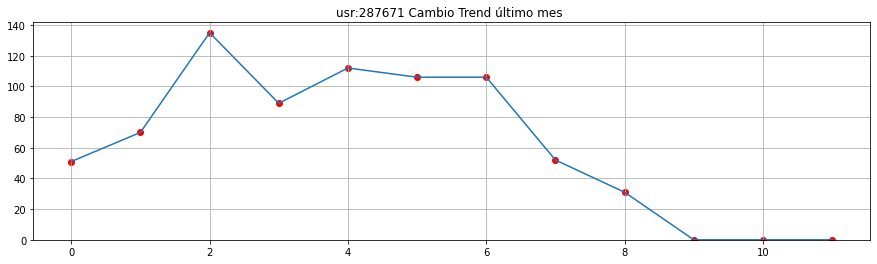

In [22]:
plt.figure(figsize=(15,4))
y = df_test[variables_consumo].loc[usr].values
x = range(len(y))
plt.plot(x,y)
plt.scatter(x,y, color='red')
plt.ylim(0.0)
# plt.legend()
plt.grid(True)
plt.title("usr:" + str(usr)+" Cambio Trend último mes ")
plt.show()

### Regla : Consumos constante

> La hipotesis de esta regla es que si existen consumos constantes por periodos largos, entonces es un posible comportamiento anomalo.
- min_count_constante : indica la cantidad minima de periodos donde los consumo son constantes.


In [23]:
min_count_constante =7
const_model = ConstantConsumptionClassifierWide(min_count_constante)
y_test_pred = const_model.predict(df_test[variables_consumo])

In [24]:
# Existen aprox un 3% de usuarios en test que cumplieron con la regla.
100*y_test_pred.value_counts(normalize=True)

0   97.13
1    2.87
dtype: float64

In [25]:
# usuario ejemplo que cumplió con la regla
usr = 312935
df_test.loc[usr]

index                                        312935
12_anterior                                   94.00
11_anterior                                   44.00
10_anterior                                   93.00
9_anterior                                    99.00
8_anterior                                    58.00
7_anterior                                     1.00
6_anterior                                     1.00
5_anterior                                     1.00
4_anterior                                     1.00
3_anterior                                     1.00
2_anterior                                     1.00
1_anterior                                     1.00
zona                                    zona_489241
actividad                          actividad_089131
tipo_tarifa                      tipo_tarifa_149261
nivel_tension                  nivel_tension_197436
material_instalacion    material_instalacion_680219
fecha_inspeccion                2018-04-01 00:00:00
target      

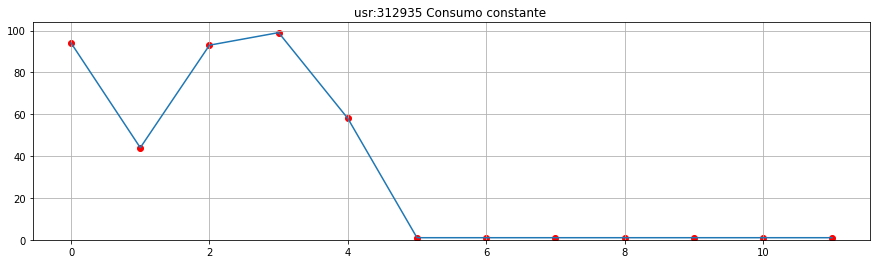

In [26]:
plt.figure(figsize=(15,4))
y = df_test[variables_consumo].loc[usr].values
x = range(len(y))
plt.plot(x,y)
plt.scatter(x,y, color='red')
plt.ylim(0.0)
# plt.legend()
plt.grid(True)
plt.title("usr:" + str(usr)+" Consumo constante ")
plt.show()

## Modelos Supervisados

### Ingenieria de variables 

> El objetivo principal es derivar variables de las serie de consumo mensual. 

**Ejemplo :** 

    1. min, maximo, pendientes.
    2. variables estadisticas,temporaales y expectrales.
    
**Paquete :**

- [TSFEL](https://tsfel.readthedocs.io/en/latest/)
- [Ejemplo de uso](https://github.com/fraunhoferportugal/tsfel/blob/master/notebooks/TSFEL_SMARTWATCH_HAR_Example.ipynb)
- Otro paquete --> [TSFRESH](https://tsfresh.readthedocs.io/en/latest/)

En el siguiente ejemplo vemos una serie de consumo, luego con el paquete TSFEL, vamos a extrar variables estadisticas que luego lo podemos usar como variables predictoras en un modelo de supervisado.

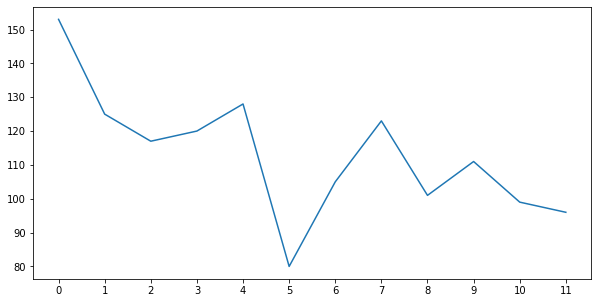

In [27]:
serie_consumo_anteriores = [153.0,  125.0,  117.0,  120.0,  128.0,  80.0,  105.0,  123.0,  101.0,  111.0,  99.0,  96.0]
plt.figure(figsize=(10,5))
plt.plot(serie_consumo_anteriores)
plt.xticks(range(12));

In [28]:
cfg = tsfel.get_features_by_domain("statistical")
df_result = tsfel.time_series_features_extractor(cfg, serie_consumo_anteriores,n_jobs=-1)

*** Feature extraction started ***
16


In [29]:
# Como resultados tenemos una diversidad de variables estadisticas como : 0_Max	0_Mean 0_Standard deviation	0_Variance, etc.
df_result.shape

(1, 36)

In [30]:
df_result[['0_Skewness','0_Kurtosis', '0_Standard deviation','0_Interquartile range', '0_Kurtosis', '0_Max', '0_Mean','0_Mean absolute deviation']]

,0_Skewness,0_Kurtosis,0_Standard deviation,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation
0,0.32,0.09,18.07,23.00,0.09,153.00,113.17,14.50


### Selección de variables 

> El objetivo es seleccionar las mejores variables para entrenar los modelos.

**Metodos y Paquete :**

- [Boruta](https://pypi.org/project/Boruta/)
- [Ejemplo de uso boruta](https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596)
- [Mutual Information](https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8)

Este paso lo realizamos luego de extraer las nuevas variables derivadas de las series de consumo. 

In [37]:
%%time
# Este paso lo vamos hacer con una muestra del conjunto de datos
variables_consumo = [x for x in df.columns if '_anterior' in x]
df_consumos = df_train[['index']+variables_consumo].head(12000)

# Construimos el pipeline de ingenieria de variables.
# TsfelVars --> Encapsula todas las funcionalidades del paquete TSFEL.
# ExtraVars --> Modulo que agrega variables extras, como cantidad de ceros seguidos en la serie de consumo y en distintas ventanas de tiempo.

pipe_feature_engeniering_consumo = Pipeline(
    [
        ("tsfel vars", TsfelVars(features_names_path=None,num_periodos= 12)),
        ("add vars3",  ExtraVars(num_periodos=3)),
        ("add vars6",  ExtraVars( num_periodos=6)),
        ("add vars12", ExtraVars(num_periodos=12)),

    ]
        )

df_features = pipe_feature_engeniering_consumo.fit_transform(df_consumos)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
CPU times: user 1min 13s, sys: 8.35 s, total: 1min 21s
Wall time: 1min 15s


>Luego de crear nuevas variables vamos a aplicar los pasos para las seleccion de las variables mas importantes.

- Eliminamos varibles constantes
- Eliminamos las que esta altamente correlacionadas
- Seleccionamos con el metod boruta

In [40]:
cols_for_feature_sel = [x for x in df_features.columns if x not in ['index'] + variables_consumo]
y_train = df_train.loc[df_features['index']].target

In [41]:
%%time
select_by_constant = feature_selection_by_constant(df_features, y_train, cols_for_feature_sel, th=0.99)
print(f" # variables No constantes {len(select_by_constant)}")

select_by_corr = feature_selection_by_correlation(df_features, y_train, select_by_constant,method='pearson', th=0.95)
print(f" # variables No correlacionadas {len(select_by_corr)}")

select_by_boruta = feature_selection_by_boruta(df_features[select_by_constant], y_train, N=5)
print(f" # variables seleccionadas por Boruta : {len(select_by_boruta)}")


 # variables No constantes 64
Calculando Correlación Entre Variables
Eliminando Variables Altamente Correlacionadas
 # variables No correlacionadas 34


100%|██████████| 5/5 [05:38<00:00, 67.62s/it]

 # variables seleccionadas por Boruta : 47
CPU times: user 44min 32s, sys: 25.1 s, total: 44min 57s
Wall time: 5min 38s


In [45]:
len(select_by_boruta)

47

### Tratamiento de las variables categoricas

> Las variables categóricas son un desafío para los algoritmos de Machine Learning. Dado que la mayoría de ellos aceptan solo valores numéricos como entradas, necesitamos transformar las categorías en números para usarlos en el modelo.

In [31]:
variables_categoricas = ['zona','actividad','material_instalacion','tipo_tarifa','nivel_tension']

In [32]:
df_train[variables_categoricas].head()

,zona,actividad,material_instalacion,tipo_tarifa,nivel_tension
50345,zona_660487,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
191551,zona_647593,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
8259,zona_660487,actividad_523376,material_instalacion_250300,tipo_tarifa_149261,nivel_tension_685394
9332,zona_489241,actividad_523376,material_instalacion_143521,tipo_tarifa_149261,nivel_tension_197436
157486,zona_647593,actividad_960696,material_instalacion_250300,tipo_tarifa_149261,nivel_tension_197436


El tratamieno de cada variable es el siguiente : 

- __actividad__:

*Reducción de cardinalidad y dummy:* 

> Variables categóricas a las que se le redujo la cardinalidad (Esta reducción se logra, por ejemplo, agrupando valores escasos que no tienen una presencia importante en el set de datos) y luego se les aplicó One-Hot-Encoding.


- __tipo_tarifa__:

*Reducción de cardinalidad y target encoding:*

>Variables categóricas a las que se le redujo la cardinalidad y luego se las reemplazó por una medida del efecto que podrían tener en el objetivo.

- __zona y nivel_tension__:

*Variables encodeadas:*

>Variables categóricas a las que se les ha aplicado OrdinalEncoder.

- __material_instalacion__:

*Target encoding:*

>Variables categóricas a las que se le redujo la cardinalidad y luego se las reemplazó por una medida del efecto que podrían tener en el objetivo.

Nota : [Target-encoding](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69) 

_Finalmente el pipeline de preprocesamiento para las variables categoricas quedo configurado como se muestra a continuacion:_

```python

pipe_actividad = Pipeline([
            ('cardinality_reducer', CardinalityReducer(threshold=0.001)),
            ('a_dummy',ToDummy(['actividad']))
        ])


pipe_tarifa = Pipeline([
            ('cardinality_reducer', CardinalityReducer(threshold=0.001)),
            ('tarifa_te',TeEncoder(['tipo_tarifa'],w=20))
        ])

vars_enc = ['zona','nivel_tension']
t_features = [
    ('var_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), vars_enc),
    ('material_isntalacion_te', TeEncoder(['material_instalacion'],w=10), ['material_instalacion']),
    ('actividad_cr_dummy', pipe_actividad, ['actividad']),
    ('tarifa_cr_te', pipe_tarifa, ['tipo_tarifa']),
    ]

preprocessor = ColumnTransformer(transformers= t_features,remainder='passthrough')

```


### Entrenamiento y evaluación de modelos supervisados


In [33]:
y_train = df_train.target.copy()
df_train = df_train.drop(columns=['target'])

y_val = df_val.target.copy()
df_val = df_val.drop(columns=['target'])

y_test = df_test.target.copy()
df_test = df_test.drop(columns=['target'])

In [34]:
# Realizamos los pasos de limpieza en los conjuntos de validacion y test.
df_val = llenar_val_vacios_ciclo(df_val, 12)
df_val = llenar_val_vacios_str(df_val,cols_fillna_sindatos,'sin_dato')

df_test = llenar_val_vacios_ciclo(df_test, 12)
df_test = llenar_val_vacios_str(df_test,cols_fillna_sindatos,'sin_dato')

In [48]:
%%time
# Calculamos las variables derivadas de las series de consumo en los 3 conjuntos de datos.
df_train = pipe_feature_engeniering_consumo.fit_transform(df_train)
df_val = pipe_feature_engeniering_consumo.transform(df_val)
df_test = pipe_feature_engeniering_consumo.transform(df_test)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [50]:
df_train.head()

,index,12_anterior,11_anterior,10_anterior,9_anterior,8_anterior,7_anterior,6_anterior,5_anterior,4_anterior,3_anterior,2_anterior,1_anterior,zona,actividad,tipo_tarifa,nivel_tension,material_instalacion,fecha_inspeccion,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Histogram_0,0_Histogram_1,0_Histogram_2,0_Histogram_3,0_Histogram_4,0_Histogram_5,0_Histogram_6,0_Histogram_7,0_Histogram_8,0_Histogram_9,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Entropy,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,mean_3,cant_ceros_3,max_cant_ceros_seg_3,slope_3,min_cons3,max_cons3,std_cons3,var_cons3,skew_cons3,mean_6,cant_ceros_6,max_cant_ceros_seg_6,slope_6,min_cons6,max_cons6,std_cons6,var_cons6,skew_cons6,kurt_cons6,mean_12,cant_ceros_12,max_cant_ceros_seg_12,slope_12,min_cons12,max_cons12,std_cons12,var_cons12,skew_cons12,kurt_cons12
0,50345,62.00,62.00,62.00,62.00,62.00,62.00,58.00,57.00,69.00,95.00,108.00,106.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-05-01,2.00,9.00,58.00,69.00,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.50,-0.45,108.00,72.08,15.46,62.00,2.00,57.00,74.37,1.16,18.28,334.24,66363.00,7.81,66363.00,0.07,0.64,5.27,4.00,1.00,0.00,1.00,0.00,51.00,1.00,63.87,4.00,58.00,603300.00,0.00,103.00,0,0,5.50,95.00,108.00,7.00,49.00,-1.57,82.17,0,0,11.97,57.00,108.00,23.63,558.17,0.01,-2.73,72.08,0,0,4.00,57.00,108.00,19.10,364.63,1.33,0.02
1,191551,92.00,87.00,82.00,74.00,82.00,85.00,86.00,96.00,126.00,104.00,119.00,132.00,zona_647593,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2017-05-01,2.00,9.00,82.00,104.00,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.50,-0.83,132.00,97.08,15.44,89.50,7.50,74.00,98.77,0.75,18.19,330.74,117071.00,10.53,117071.00,0.07,0.95,10.91,3.64,8.00,3.00,2.00,0.00,58.00,1.00,121.06,4.14,120.00,1064281.82,0.00,118.33,0,0,14.00,104.00,132.00,14.01,196.33,-0.21,110.50,0,0,7.91,86.00,132.00,18.04,325.50,-0.19,-1.74,97.08,0,0,4.14,74.00,132.00,19.00,360.81,0.86,-0.58
2,8259,20.00,19.00,27.00,33.00,21.00,21.00,21.00,23.00,18.00,15.00,10.00,14.00,zona_660487,actividad_523376,tipo_tarifa_149261,nivel_tension_685394,material_instalacion_250300,2016-01-01,2.00,9.00,14.00,21.00,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.25,0.24,33.00,20.17,4.17,20.50,2.50,10.00,20.97,0.45,5.74,32.97,5276.00,2.25,5276.00,0.04,0.89,4.18,-0.55,4.00,0.00,2.00,0.00,23.00,2.00,49.32,-1.05,46.00,47963.64,0.00,13.00,0,0,-0.50,10.00,15.00,2.65,7.00,-1.46,16.83,0,0,-2.20,10.00,23.00,4.79,22.97,-0.11,-0.93,20.17,0,0,-1.05,10.00,33.00,6.00,35.97,0.52,1.11
3,9332,212.00,205.00,289.00,221.00,193.00,130.00,142.00,139.00,132.00,140.00,142.00,175.00,zona_489241,actividad_523376,tipo_tarifa_149261,nivel_tension_197436,material_instalacion_143521,2016-01-01,2.00,9.00,132.00,205.00,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,67.00,0.15,289.00,176.67,39.44,158.50,27.50,130.00,182.75,0.98,46.77,2187.06,400778.00,19.27,400778.00,0.04,0.95,28.64,-3.36,12.00,-3.00,3.00,0.00,159.00,2.00,315.70,-9.13,315.00,3643436.36,0.00,152.33,0,0,17.50,140.00,175.00,19.66,386.33,1.71,145.00,0,0,5.20,132.00,175.00,15.15,229.60,2.10,4.91,176.67,0,0,-9.13,130.00,289.00,48.85,2385.88,1.12,0.97
4,157486,45.00,43.00,4

In [ ]:
# levantar previamente calculadas
# df_train = pd.read_parquet('../datos/preprocesados/df_train_p.parquet')
# df_val = pd.read_parquet('../datos/preprocesados/df_val_p.parquet')
# df_test = pd.read_parquet('../datos/preprocesados/df_test_p.parquet')
# select_by_boruta = pd.read_csv('../datos/preprocesados/features.csv')['features'].tolist()

In [36]:
# Definimos las variables finales para el entrenamiento de los modelos.
feauture_selected = select_by_boruta
cols_for_model = variables_categoricas+variables_consumo+feauture_selected

In [37]:
# Definimos el metodo de balanceo de clases con su correspondiente umbral y el pipeline de pre-procesamiento de variables categoricas.
param_imb_method = 'under'
sam_th = 0.2
periodo = 12
preprocesor = 4 # Pipeline de variables categoricas

In [38]:
resulado_final = {} # para guardar todas las metricas obtenidas

#### LGBM

In [39]:
%%time
train_lgbm_model = LGBMModel(cols_for_model,
                             hyperparams=None,
                             search_hip=True,
                             sampling_th = sam_th,
                             preprocesor_num = preprocesor,
                             sampling_method=param_imb_method)
lgbm_model = train_lgbm_model.train(df_train,y_train,df_val, y_val)


Best score reached: 0.7184494499908558 with params: {'lgbmclassifier__colsample_bytree': 0.5724726792874275, 'lgbmclassifier__learning_rate': 0.09042371348412374, 'lgbmclassifier__max_bin': 128, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__min_child_samples': 240, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__num_leaves': 40, 'lgbmclassifier__reg_alpha': 5, 'lgbmclassifier__reg_lambda': 0.001, 'lgbmclassifier__scale_pos_weight': 5, 'lgbmclassifier__subsample': 0.8087445946527063, 'lgbmclassifier__subsample_freq': 11} 
CPU times: user 7.41 s, sys: 656 ms, total: 8.06 s
Wall time: 13.5 s


In [40]:
y_pred_test_lgbm = lgbm_model.predict_proba(df_test[cols_for_model])[:,1]
resulado_final[f'{param_imb_method}-lgbm'] = y_pred_test_lgbm

In [41]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lgbm))

AUC Test:  0.776


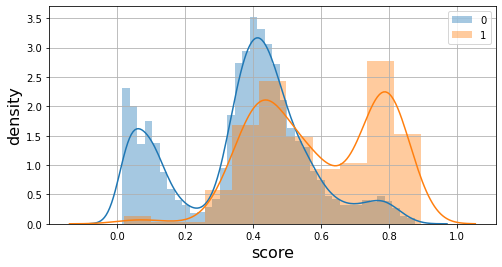

In [42]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lgbm[y_test==0], label='0')
sns.distplot(y_pred_test_lgbm[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

#### NN

In [43]:
%%time
features_names = variables_categoricas + feauture_selected
spents_names = variables_consumo
train_nn_model = NNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
rnn_model,pipe_features,pipe_spent = train_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00069: early stopping
CPU times: user 30.1 s, sys: 16.6 s, total: 46.7 s
Wall time: 7.12 s


In [44]:
X_features = pipe_features.transform(df_test[features_names])
X_spents = pipe_spent.transform(df_test[spents_names])
X_test_features = np.concatenate([X_features,X_spents],axis=1)

In [45]:
y_pred_test_rnn = rnn_model.predict(X_test_features, batch_size=train_nn_model.BATCH_SIZE)
resulado_final[f'{param_imb_method}-ffn'] = y_pred_test_rnn

In [46]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_rnn))

AUC Test:  0.735


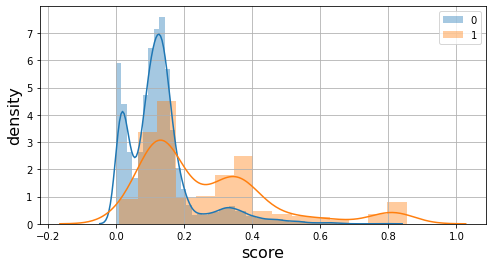

In [47]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

#### LSTM-NN

In [48]:
%%time
features_names = variables_categoricas + feauture_selected
spents_names = variables_consumo
lstm_nn_model = LSTMNNModel(features_names,spents_names,sampling_th = sam_th,preprocesor_num = preprocesor,sampling_method=param_imb_method)
lstm_rnn_model,pipe_features,pipe_spent = lstm_nn_model.train(df_train,y_train)

Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping
CPU times: user 6min 21s, sys: 5min 3s, total: 11min 25s
Wall time: 52.9 s


In [49]:
X_test_features = pipe_features.transform(df_test[features_names])
X_test_spents = pipe_spent.transform(df_test[spents_names])
X_test_spents = X_test_spents.reshape((X_test_spents.shape[0],periodo,1))

In [50]:
y_pred_test_lstm_rnn = lstm_rnn_model.predict([X_test_spents, X_test_features],batch_size=lstm_nn_model.BATCH_SIZE)[:,0]
resulado_final[f'{param_imb_method}-lstm-ffn'] = y_pred_test_lstm_rnn

In [51]:
print("AUC Test:  %.3f" %  roc_auc_score(y_test,y_pred_test_lstm_rnn))

AUC Test:  0.734


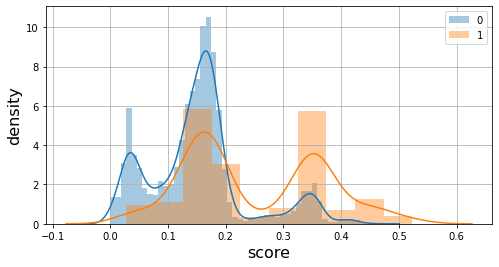

In [52]:
plt.figure(figsize=(8,4))
sns.distplot(y_pred_test_lstm_rnn[y_test==0], label='0')
sns.distplot(y_pred_test_lstm_rnn[y_test==1], label='1')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

#### Resultados modelos superisados

In [53]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (10, 6)

,metodo,auc
0,under-lgbm,0.78
1,under-ffn,0.74
2,under-lstm-ffn,0.73


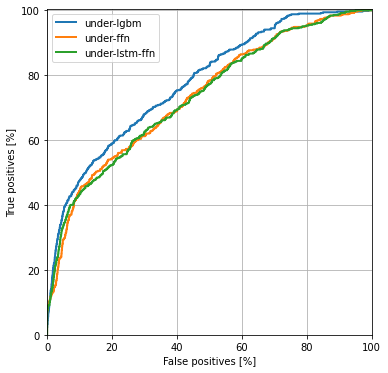

In [54]:
l_m_auc = []

for i,x in enumerate(resulado_final.keys()):
    plot_roc(x, y_test,resulado_final[x] , color=colors[i])
    m_auc = roc_auc_score(y_test,resulado_final[x])
    l_m_auc.append((x,m_auc))
plt.legend();

pd.DataFrame(l_m_auc, columns=['metodo','auc']).sort_values('auc',ascending=False)